## Introduction
will be sth

In [ ]:
from random import random
!pip install torch torchmetrics torchvision 

## Imports

In [113]:
# PyTorch 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

# Standard library imports
import os
import shutil
import zipfile
import random
from pathlib import Path
from collections import Counter

# Data manipulation and numerical operations
import numpy as np

# Image processing and visualization
import matplotlib.pyplot as plt
from PIL import Image

# Third-party libraries
import gdown

### Device

In [96]:
# Setting device
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
  device = "mps"
elif torch.device("cpu"):
  device = "cpu"

print("The type of devise: ", device)
print("The version of torch:", torch.__version__)

The type of devise:  mps
The version of torch: 2.7.0


# Loading and Data Preprocessing

In [97]:
def extract_gdrive_file(folder_id, output_path):
    '''
    Download and extract a ZIP file from Google Drive.
    Parameters:
    - folder_id (str): The unique ID of the file from G Drive link.
    - output_path (str): The path where the files will be extracted.
    '''
    # check whether the data already exists
    if os.path.exists(output_path) and len(os.listdir(output_path)) > 0:
        print("Data already exists. I'm skipping the downloading and unpacking.")
        return

    # create file for extracted files, if not existed
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # download file from Google Drive
    zip_url = f"https://drive.google.com/uc?export=download&id={folder_id}"
    zip_filename = os.path.join(output_path, "brain_tumors_img.zip")
    print(f"Downloading file from Google Drive to {zip_filename}...")
    gdown.download(zip_url, zip_filename, quiet=False)

    # extract the file to output path
    print(f"Unzipping file: {zip_filename}...")
    try:
        with zipfile.ZipFile(zip_filename, "r") as zip_ref:
            zip_ref.extractall(output_path)
        print("Unzipping of the file is complete!")
    except zipfile.BadZipFile:
        print("Error: The downloaded file is not a valid ZIP archive.")
        return

    # delete zip file after extraction
    os.remove(zip_filename)
    print("ZIP file has been removed!")

    # Remove the _MACOSX folder if exists
    macosx_path = os.path.join(output_path, '__MACOSX')
    if os.path.exists(macosx_path):
        shutil.rmtree(macosx_path)
        print("_MACOSX folder has been removed!")

    # Remove .DS_Store files from the extracted folders
    for root, dirs, files in os.walk(output_path):
        for file in files:
            if file == ".DS_Store":
                file_path = os.path.join(root, file)
                os.remove(file_path)
                print(f"Removed file: {file_path}")



FOLDER_ID = "1xHeIOOHUFlnTxuSJzwuoVMmb3iz-oHlB"
OUTPUT_PATH = "./data/tumors"
extract_gdrive_file(FOLDER_ID, OUTPUT_PATH)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1xHeIOOHUFlnTxuSJzwuoVMmb3iz-oHlB
From (redirected): https://drive.google.com/uc?export=download&id=1xHeIOOHUFlnTxuSJzwuoVMmb3iz-oHlB&confirm=t&uuid=9e566512-b75b-4a00-bf1e-0fb651183a95
To: /Users/franekbiskup/Desktop/Portfolio/brain_tumors/data/tumors/brain_tumors_img.zip
100%|██████████| 159M/159M [00:29<00:00, 5.41MB/s] 


Unzipping file: ./data/tumors/brain_tumors_img.zip...
Unzipping of the file is complete!
ZIP file has been removed!
_MACOSX folder has been removed!
Removed file: ./data/tumors/brain_tumors_img/.DS_Store
Removed file: ./data/tumors/brain_tumors_img/Training/.DS_Store
Removed file: ./data/tumors/brain_tumors_img/Testing/.DS_Store


In [98]:
# directories for images
train_dir = Path('data/tumors/brain_tumors_img/Training')
test_dir = Path('data/tumors/brain_tumors_img/Testing')
train_dir, test_dir

(PosixPath('data/tumors/brain_tumors_img/Training'),
 PosixPath('data/tumors/brain_tumors_img/Testing'))

In [99]:
categories = os.listdir(train_dir)
print(categories)

['pituitary', 'notumor', 'glioma', 'meningioma']


In [100]:
def load_data(train_dir, test_dir):
    dataset_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    train_dataset = torchvision.datasets.ImageFolder(root = train_dir, transform = dataset_transforms)
    test_dataset  = torchvision.datasets.ImageFolder(root = test_dir, transform = dataset_transforms)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True) # try others batch_size eg. 64, 128, 256, 512
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    return train_dataset, test_dataset, train_loader, test_loader

In [101]:
train_dataset, test_dataset, train_loader, test_loader = load_data(train_dir, test_dir)

### Data vizualization

In [102]:
CLASS_NAMES = ['glioma', 'meningioma', 'notumor','pituitary'] 

def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=15, shuffle = True)
    batch = next(iter(loader))
    images, labels = batch

    plt.figure(figsize = (12,8))
    for i, img in enumerate(images):
      plt.subplot(3, 5, i+1)
      plt.imshow(np.transpose(img, (1,2,0)))
      plt.title(categories[labels[i].item()])
      plt.axis('off')

    plt.tight_layout()
    plt.show()



def plot_class_distribution(dataset, dataset_name,class_names=CLASS_NAMES):
    labels = [label for _, label in dataset]
    label_counts = Counter(labels)
    label_counts = {class_names[key]: value for key, value in label_counts.items()}
                   

    plt.figure(figsize=(8, 6))
    plt.bar(label_counts.keys(), label_counts.values(), color=['navy', 'teal', 'darkorange', 'crimson'])
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.title(f"{dataset_name} Set Distribution")
    plt.show()

In [103]:
# Print out some info about data
print("Number of images in the training set:")
print("Pituitary: ", len(os.listdir(train_dir / 'pituitary')))
print("No tumor: ", len(os.listdir(train_dir / 'notumor')))
print("Glioma: ", len(os.listdir(train_dir / 'glioma')))
print("Meningioma: ", len(os.listdir(train_dir / 'meningioma')), '\n')

print("Number of images in the test set:")
print("Pituitary: ", len(os.listdir(test_dir / 'pituitary')))
print("No tumor: ", len(os.listdir(test_dir / 'notumor')))
print("Glioma: ", len(os.listdir(test_dir / 'glioma')))
print("Meningioma: ", len(os.listdir(test_dir / 'meningioma')), '\n')

Number of images in the training set:
Pituitary:  1457
No tumor:  1595
Glioma:  1321
Meningioma:  1339 

Number of images in the test set:
Pituitary:  300
No tumor:  405
Glioma:  300
Meningioma:  306 



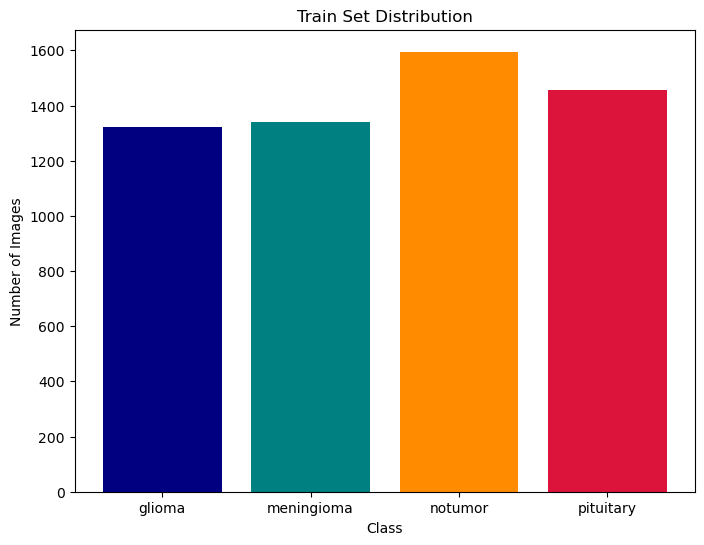

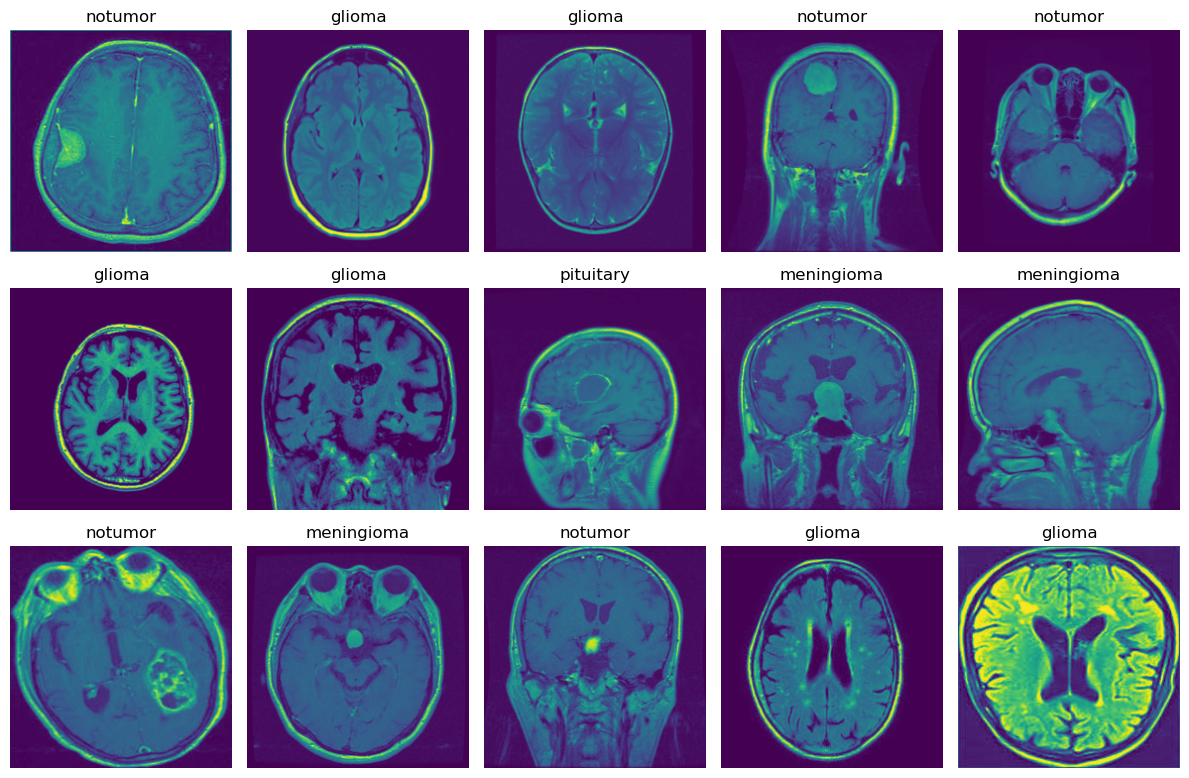

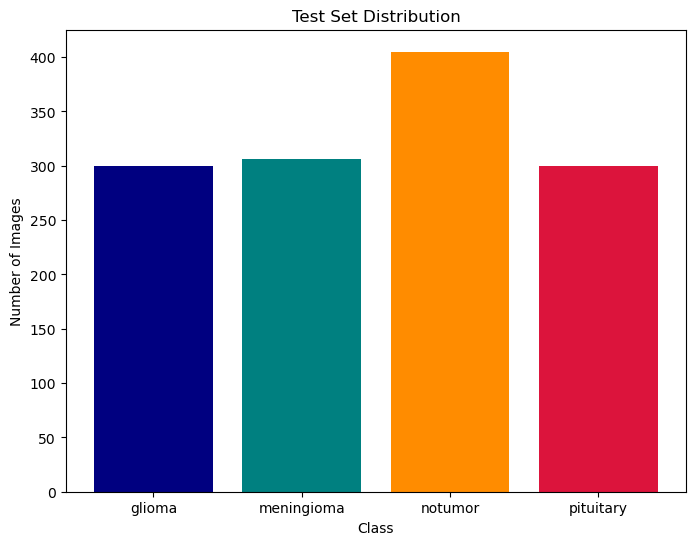

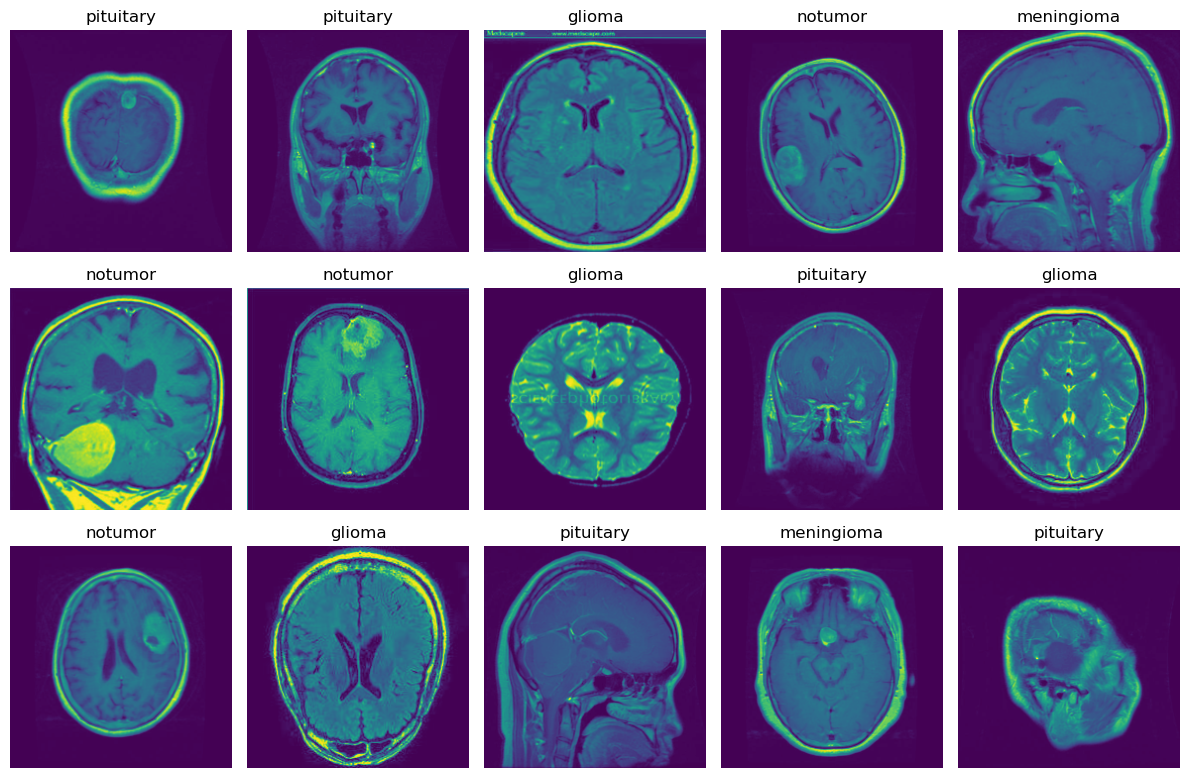

In [104]:
plot_class_distribution(train_dataset, "Train")
show_transformed_images(train_dataset)
plot_class_distribution(test_dataset, "Test")
show_transformed_images(test_dataset)

### Data Inbalance
As we can see our images dataset is a little bit inbalanced- we have more **no tumor** image samples. In the next stages of the project we will increase the number of samples, with two techniques:
1. Data augmentation
2. Generative Adversarial Networks called GANs

And then we will compare those methods (maybe we will combine them) and see which one is more effective.


# Data Augmentation

## Setting the Transformers

In [105]:
transformer = {
    'dataset1' : transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.Grayscale(num_output_channels=1)
    ]),
    
    'dataset2' : transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomRotation(5),
        transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
        transforms.Grayscale(num_output_channels=1)
    ]),
    
    'dataset3' : transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(1),
        transforms.RandomResizedCrop(224, scale=(0.3, 0.3)),
        transforms.Grayscale(num_output_channels=1)
    ])
}

## Create augmented images

In [106]:
# desired number of images for each tumor type
DESIRED_IMG = 4000

# directory for augmented images
train_aug_dir = Path('data/tumors/brain_tumors_img/Training_augmented')

In [107]:
def create_dir(input_dir, output_dir):
    # create folder for new images
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # create subfolders for each label
    for label in CLASS_NAMES:
        input_subfolder = os.path.join(input_dir, label)
        output_subfolder = os.path.join(output_dir, label)
        os.makedirs(output_subfolder, exist_ok=True)
        
        # copy images from input_dir to output_dir
        if os.path.isdir(input_subfolder):
            for filename in os.listdir(input_subfolder):
                input_path = os.path.join(input_subfolder, filename)
                output_path = os.path.join(output_subfolder, filename)
                if os.path.isfile(input_path) and not os.path.exists(output_path):
                    shutil.copy2(input_path, output_path)
        else:
            print(f"WARNING: source folder {input_subfolder} does not exist")           


def image_augmentation(input_dir, output_dir):
    # create folder to save the images
    create_dir(input_dir, output_dir)
    
    for label in CLASS_NAMES:
        img_folder = output_dir / label
        # count how many images has to be augmented
        existing_img = list(img_folder.glob('*.jpg'))
        num_existing_img = len(existing_img)
        num_to_generate = DESIRED_IMG - num_existing_img

        if num_to_generate <= 0:
            print(f"{label}: already has {num_existing_img} augmented images, skipping.")
            continue

        print(f"Augmenting '{label}': need {num_to_generate} more images...")
        # image augmentation
        for i in range(num_to_generate):
            img_path = random.choice(existing_img)
            img = Image.open(img_path)
            key = random.choice(list(transformer.keys()))
            aug_img = transformer[key](img)
            save_path = img_folder / f"{label}_aug_{i + 1}.png"
            aug_img.save(save_path)

        print(f"Saved {num_to_generate} images to: {img_folder}. \n")

In [108]:
image_augmentation(train_dir, train_aug_dir)

Augmenting 'glioma': need 2679 more images...
Saved 2679 images to: data/tumors/brain_tumors_img/Training_augmented/glioma. 

Augmenting 'meningioma': need 2661 more images...
Saved 2661 images to: data/tumors/brain_tumors_img/Training_augmented/meningioma. 

Augmenting 'notumor': need 2405 more images...
Saved 2405 images to: data/tumors/brain_tumors_img/Training_augmented/notumor. 

Augmenting 'pituitary': need 2543 more images...
Saved 2543 images to: data/tumors/brain_tumors_img/Training_augmented/pituitary. 



In [109]:
print("Number of images in the training set:")
print("Pituitary: ", len(os.listdir(train_aug_dir / 'pituitary')))
print("No tumor: ", len(os.listdir(train_aug_dir / 'notumor')))
print("Glioma: ", len(os.listdir(train_aug_dir / 'glioma')))
print("Meningioma: ", len(os.listdir(train_aug_dir / 'meningioma')), '\n')

Number of images in the training set:
Pituitary:  4000
No tumor:  4000
Glioma:  4000
Meningioma:  4000 



# Generative Adversarial Networks (GAN)

# Define the model


## Models architecture

### simple CNN 

In [110]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 4)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### ResNet model

### VGG model

## Training models

In [111]:
def train_model(model, train_loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

## Model evaluation

In [112]:
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1) # outputs.data, 1
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Model evaluation

### Saving the model